# Exercice 13) Deep Deterministic Policy Gradients and Proximal Policy Optimization

In this exercise we will investigate two state-of-the-art algorithms: deep deterministic policy gradient (DDPG) and proximal policy optimization (PPO).

We will examine their performance on [Goddard's rocket problem](https://github.com/osannolik/gym-goddard).
This environment comes prepackaged in this notebook's folder, so it can be just imported.

```
First formulated by R. H. Goddard around 1910, this is a classical problem within dynamic optimization and optimal control. The task is simply to find the optimal thrust profile for a vertically ascending rocket in order for it to reach the maximum possible altitude, given that its mass decreases as the fuel is spent and that it is subject to varying drag and gravity.

The state, and the gym's observation space, of the rocket is its vertical position, velocity and mass.

The rocket engine is assumed to be throttled such that the thrust can be continuously controlled between 0 to some maximum limit.
```

![](https://github.com/osannolik/gym-goddard/blob/master/animation.gif)

In [1]:
from rocket_env import GoddardEnv
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1) DDPG

## 2) PPO

The [original paper from 2017](https://arxiv.org/abs/1707.06347) for the PPO came up with an idea to combine A2C (having multiple workers) and TRPO (using a trust region to improve the actor).
The PPO algorithm achieves this by hard clipping gradients in order to ensure that new policies won't be too far away from old ones.

In [15]:
from stable_baselines3 import PPO, DDPG, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import torch


class Pbar(BaseCallback):
    def __init__(self, total, n_rollout_steps):
        super().__init__()
        self.n_steps = n_rollout_steps
        self.pbar = tqdm(desc='Training', total=total)
        
    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        self.pbar.update(self.n_steps)
    
    def _on_step(self) -> bool:
        return True

    
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[8], vf=[8])])

n_steps = 256  # an episode takes around ~250 steps
total_timesteps = n_steps*250  # steps_per_episode * episodes

repeats = 5
logs = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv())
    model = PPO('MlpPolicy', env, n_steps=n_steps, n_epochs=50,  verbose=0, device='cpu', learning_rate=1e-4, batch_size=n_steps, policy_kwargs=policy_kwargs)
    model = model.learn(total_timesteps=total_timesteps, callback=Pbar(total_timesteps, n_steps))
    logs['envs'] += [env]
    logs['models'] += [model]

Training:   0%|          | 0/64000 [00:00<?, ?it/s]

Training:   0%|          | 0/64000 [00:00<?, ?it/s]

Training:   0%|          | 0/64000 [00:00<?, ?it/s]

Training:   0%|          | 0/64000 [00:00<?, ?it/s]

Training:   0%|          | 0/64000 [00:00<?, ?it/s]

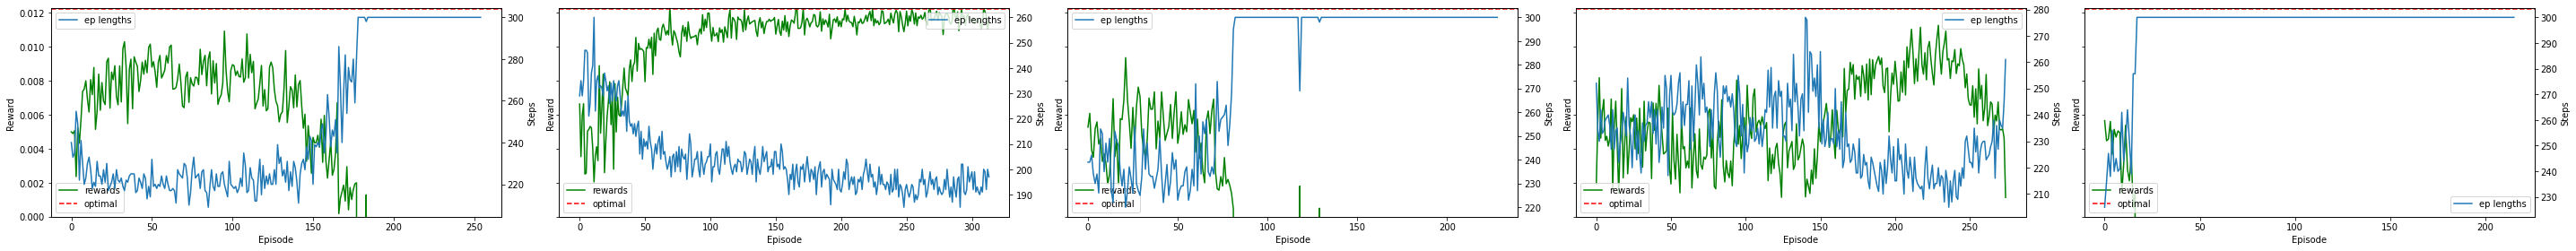

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=repeats, figsize=(repeats*8, 4), sharey=True)
for ax, _env, _model in zip(axes, logs['envs'], logs['models']):
    ax.plot(_env.get_episode_rewards(), label='rewards', color='green')
    
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episode')
    ax.set_ylim(0, 0.0123)
    ax.axhline(0.0122079818367078, ls='--', color='red', label='optimal')
    ax.legend(loc='lower left')
    ax2 = ax.twinx()
    ax2.plot(_env.get_episode_lengths(), label='ep lengths')
    ax2.legend()
    ax2.set_ylabel('Steps')
fig.tight_layout()

In [4]:
n_episodes = 1
#model = PPO('MlpPolicy', env, n_steps=1280, n_epochs=100,  verbose=0, device='cpu', learning_rate=1e-3, batch_size=64)
max_steps_per_episode = 500
tst_logs = {'rewards': []}

for ep in range(n_episodes):
    obs = env.reset()
    done = False
    cum_rew = 0
    k = 0
    while not done and k < max_steps_per_episode:
        action, _ = model.predict(obs, deterministic=True) #
        obs, reward, done, info = env.step(action)
        env.render()
        cum_rew += reward
        k += 1

    tst_logs['rewards'].append(cum_rew)
rewards = np.array(tst_logs['rewards']).ravel()
env.close()

In [5]:
print(f'Mean reward ± std.dev: {rewards.mean():.6f} ± {rewards.std()}, best: {rewards.max()}')

Mean reward ± std.dev: 0.011887 ± 0.0, best: 0.011886511700592406


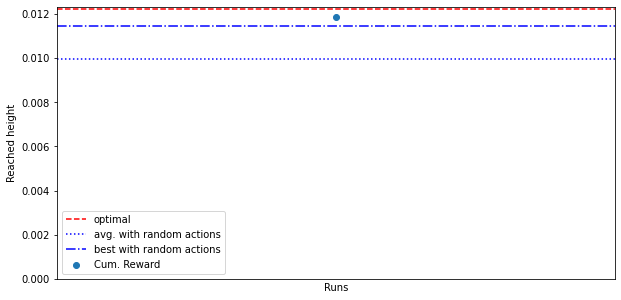

In [6]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(np.random.randn(rewards.size), rewards, label='Cum. Reward')
# source: https://github.com/osannolik/gym-goddard/blob/master/gym_goddard/envs/optimal_control.ipynb
plt.axhline(0.0122079818367078, ls='--', color='red', label='optimal')
# own experiments
plt.axhline(0.00995, ls=':', color='blue', label='avg. with random actions')
plt.axhline(0.01148, ls='-.', color='blue', label='best with random actions')
plt.xlabel('Runs')
plt.ylabel('Reached height')
plt.ylim(0, None)
plt.xticks([])
plt.title('')
plt.legend()
